![title](images/bluescreen.jpg)

# Movie Genre Profitability for Microsoft

**Author:** Nicholas Gigliotti

**Pace:** Full time

**Review Date:** 3/25/21

**Instructor:** James Irving

## Overview

I conduct an analysis of the profitability of different movie genres in relation to production budget for Microsoft. Microsoft wants to enter the movie business and develop original content. They will have to decide which genres they wish to invest in early on, since different genres have different production requirements. I conclude that Microsoft should invest in horror for low-budget productions and animation for high-budget productions. Horror has the strongest correlation with return on investment (ROI) of any genre, overall. I further conclude that Microsoft should stay away from drama, action, and crime movies because these are negatively correlated with ROI.

## Business Problem

Microsoft has decided to enter the movie business and create original material. They want to know what kinds of movies are currently profitable, and they want concrete, actionable, insights.

In my analysis, I attempt to answer the following questions for Microsoft:

1. What genres have the strongest correlation with return on investment?
2. How does budget affect these correlations?
3. Are high or low-budget films more profitable?

### Why Genre?
Different film genres have different markets, and need to be created by different groups of artists. Choosing which genres to invest in is one of the most fundamental early decisions Microsoft will have to make.

## Data Understanding

I use data from two sources in my analysis: [The Numbers](https://www.the-numbers.com/movie/budgets "The Numbers") and the [Internet Movie Database](https://www.imdb.com/interfaces/ "Internet Movie Database") (IMDb). IMDb is an expansive and easily accessible source of movie data which, most importantly, includes genre labels for thousands of films. IMDb lacks financial data, however, so I am forced to rely on The Numbers.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import utils
import cleaning
import plotting

%matplotlib inline
sns.set(font_scale=1.25, style='darkgrid', palette='deep')
pd.options.display.float_format = '{:,.2f}'.format

### The Numbers
My financial data comes from a website called "The Numbers" which has a healthy collection of production budget and revenue data. The Numbers is owned by Nash Information Services, a movie industry research and consulting firm. The most important columns for my analysis are `production_budget`, `domestic_gross`, and `worldwide_gross`. I use these columns later to calculate profit and return on investment (ROI).

The table includes a little under 6,000 observations.

In [2]:
tn = pd.read_csv(os.path.join('zippedData', 'tn.movie_budgets.csv.gz'),
                 parse_dates=['release_date'])
tn

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,"$7,000",$0,$0
5778,79,1999-04-02,Following,"$6,000","$48,482","$240,495"
5779,80,2005-07-13,Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,2015-09-29,A Plague So Pleasant,"$1,400",$0,$0


### Internet Movie Database
My genre data comes from IMDb, a subsidiary of Amazon which is a well known source of movie information. Naturally, the most important column for my analysis will be `genres`. I later use this column to compute Pearson correlations between genres and different financial statistics.

This table is much larger than `tn`, with a little over 146,000 observations.

In [3]:
imdb = pd.read_csv(os.path.join('zippedData', 'imdb.title.basics.csv.gz'))
imdb

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.00,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,nan,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,nan,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.00,NaN


## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

### The Numbers
I start by replacing the incorrect `id` column with a column of genuinely unique ID numbers. I also create a `release_year` column, because it will come in handy later when merging tables.

In [4]:
del tn['id']
tn.insert(0, 'tn_id', np.arange(tn.shape[0]) + 1)
tn.insert(2, 'release_year', tn['release_date'].dt.year)
tn.head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,2009,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,2011-05-20,2011,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,2019-06-07,2019,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,2015-05-01,2015,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,2017-12-15,2017,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


The columns `production_budget`, `domestic gross`, and `worldwide gross` are in string format, so I remove the extraneous symbols and convert them to `np.float64`.

In [5]:
money_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
tn[money_cols] = (tn.loc[:, money_cols]
                    .apply(cleaning.process_strings)
                    .apply(lambda x: x.astype('float64')))
tn.sort_values('worldwide_gross').head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
5037,5038,2019-04-23,2019,Living Dark: The Story of Ted the Caver,"1,750,000.00",0.00,0.00
3975,3976,2015-05-15,2015,Pound of Flesh,"7,500,000.00",0.00,0.00
4627,4628,2011-06-28,2011,2:13,"3,500,000.00",0.00,0.00
4628,4629,2013-01-29,2013,"Batman: The Dark Knight Returns, Part 2","3,500,000.00",0.00,0.00
3947,3948,2019-06-21,2019,Burn Your Maps,"8,000,000.00",0.00,0.00


These 0 values for `domestic_gross` and `worldwide_gross` look very suspicious. Some of these 0s are for Netflix original productions such as *Bright* and *The Ridiculous 6*. Obviously those should not be counted as massive commercial failures simply because they were not released in theaters. Other 0s are for movies like *PLAYMOBIL*, which other sources report as generating revenue. Still other 0s are for movies which were released only domestically or only abroad.

In [6]:
tn.query('(domestic_gross == 0) & (worldwide_gross == 0)').head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
194,195,2020-12-31,2020,Moonfall,"150,000,000.00",0.00,0.00
479,480,2017-12-13,2017,Bright,"90,000,000.00",0.00,0.00
480,481,2019-12-31,2019,Army of the Dead,"90,000,000.00",0.00,0.00
535,536,2020-02-21,2020,Call of the Wild,"82,000,000.00",0.00,0.00
670,671,2019-08-30,2019,PLAYMOBIL,"75,000,000.00",0.00,0.00


I remove any rows where the domestic or worldwide gross is 0, since nearly every 0 is a null value or error.

In [7]:
tn = tn.loc[tn.query('(domestic_gross > 0) & (worldwide_gross > 0)').index]
tn.sort_values('worldwide_gross').head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
5770,5771,2008-08-14,2008,The Rise and Fall of Miss Thang,"10,000.00",401.00,401.00
5518,5519,2005-10-13,2005,The Dark Hours,"400,000.00",423.00,423.00
5769,5770,1996-04-01,1996,Bang,"10,000.00",527.00,527.00
5466,5467,2018-05-11,2018,Higher Power,"500,000.00",528.00,528.00
5027,5028,1993-01-01,1993,Ed and his Dead Mother,"1,800,000.00",673.00,673.00


Looks like the data extends back in time much farther than I want.

Text(0, 0.5, 'Count')

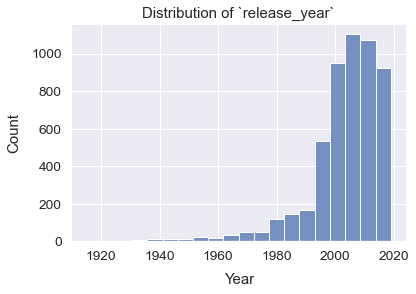

In [8]:
ax = sns.histplot(data=tn, x='release_year', bins=20, palette='deep')
ax.set_title('Distribution of `release_year`')
ax.set_xlabel('Year', labelpad=10)
ax.set_ylabel('Count', labelpad=10)

I drop everything earlier than 2009 because I'm only interested in data that's relevant to current box office performance. 2020 was a particularly bad year because of the COVID-19 pandemic, so I leave that out as well.

In [9]:
tn = tn.loc[tn.query('(release_year <= 2019) & (release_year >= 2009)').index]
tn.sort_values('release_date').head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
2934,2935,2009-01-09,2009,The Unborn,"16,000,000.00","42,670,410.00","78,208,812.00"
4318,4319,2009-01-09,2009,Not Easily Broken,"5,000,000.00","10,572,742.00","10,732,909.00"
1880,1881,2009-01-09,2009,Bride Wars,"30,000,000.00","58,715,510.00","115,150,424.00"
1164,1165,2009-01-16,2009,Defiance,"50,000,000.00","28,644,813.00","52,987,754.00"
2736,2737,2009-01-16,2009,Notorious,"19,000,000.00","36,843,682.00","44,972,183.00"


Looks like all of the basic money distributions are very right-skewed, which is not surprising. I expect there to be many more small films than big films, financially-speaking.

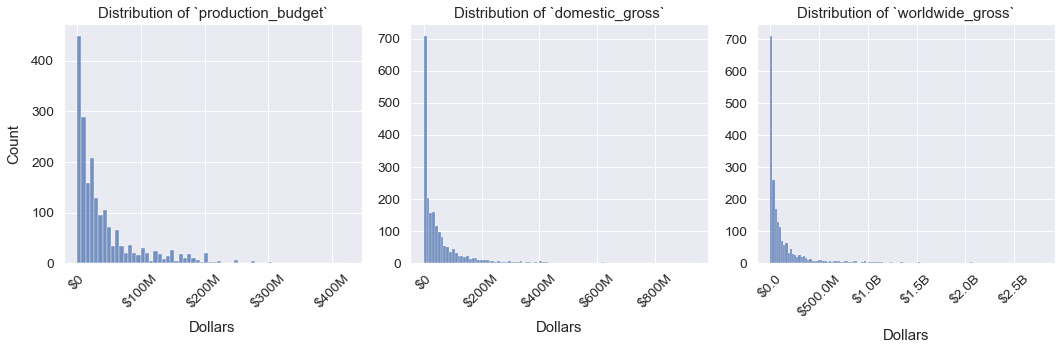

In [10]:
axs = plotting.multi_hist(tn, include=money_cols, xlabel='Dollars', palette='deep')
for ax in axs:
    ax.xaxis.set_major_formatter(plotting.big_money_formatter())
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
axs[2].xaxis.set_major_formatter(plotting.big_money_formatter(1))
plt.tight_layout()

These box plots indicate that there are many extreme values in the dataset. The data points beyond the upper whiskers are not truly outliers in this case. *Avatar* really does have a worldwide gross of 2.8 billion dollars. There is not a good scientific reason to altar or remove these values.

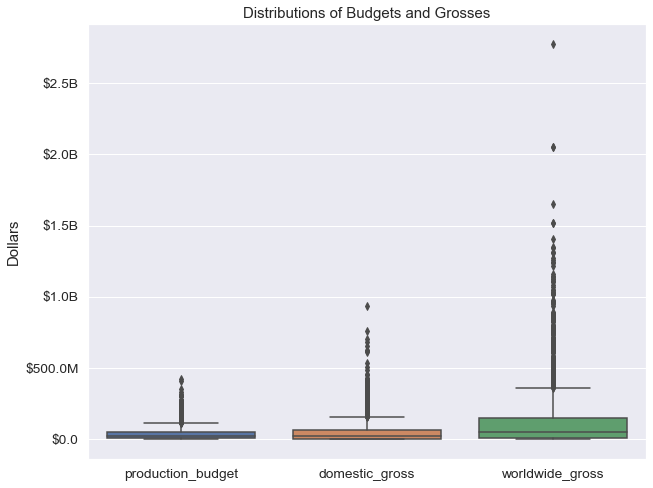

In [11]:
fix, ax = plt.subplots(figsize=(10, 8))
ax = sns.boxplot(data=tn[money_cols],
                 ax=ax,
                palette='deep')
ax.set_title('Distributions of Budgets and Grosses')
ax.set_ylabel('Dollars')
ax.yaxis.set_major_formatter(plotting.big_money_formatter(1))

#### Financial Calculations
I calculate domestic and worldwide profit by subtracting `production_budget` from each respective gross column.

In [12]:
tn['worldwide_profit'] = tn.eval('worldwide_gross - production_budget')
tn['domestic_profit'] = tn.eval('domestic_gross - production_budget')
tn.sort_values('worldwide_profit', ascending=False).head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit
0,1,2009-12-18,2009,Avatar,"425,000,000.00","760,507,625.00","2,776,345,279.00","2,351,345,279.00","335,507,625.00"
6,7,2018-04-27,2018,Avengers: Infinity War,"300,000,000.00","678,815,482.00","2,048,134,200.00","1,748,134,200.00","378,815,482.00"
5,6,2015-12-18,2015,Star Wars Ep. VII: The Force Awakens,"306,000,000.00","936,662,225.00","2,053,311,220.00","1,747,311,220.00","630,662,225.00"
33,34,2015-06-12,2015,Jurassic World,"215,000,000.00","652,270,625.00","1,648,854,864.00","1,433,854,864.00","437,270,625.00"
66,67,2015-04-03,2015,Furious 7,"190,000,000.00","353,007,020.00","1,518,722,794.00","1,328,722,794.00","163,007,020.00"


The distribution of `domestic_profit` is almost symmetrical around 0, although it is still right-skewed overall. The distribution of `worldwide_profit` is even more right-skewed. In both distributions the positive skew indicates that there are more winners than losers. This is unsurprising, since production companies strive to generate profit.

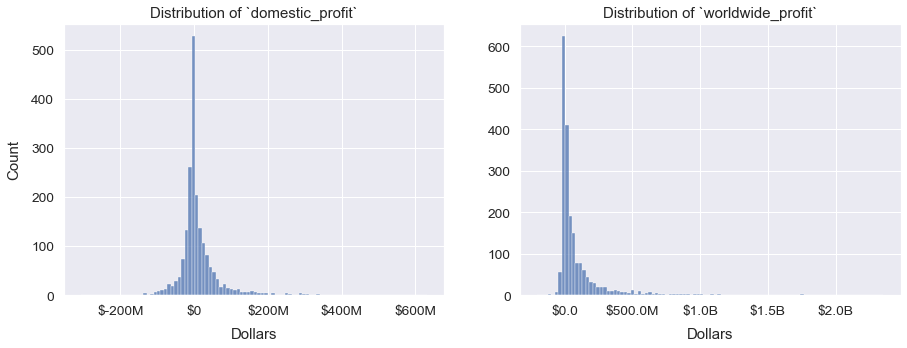

In [13]:
axs = plotting.multi_hist(tn,
                         include=['domestic_profit', 'worldwide_profit'],
                         xlabel='Dollars',
                         bins=100)
axs[0].xaxis.set_major_formatter(plotting.big_money_formatter())
axs[1].xaxis.set_major_formatter(plotting.big_money_formatter(1))

I calculate the percent return on investment (ROI) by dividing profit by budget and multiplying by 100. The sorted result is... ominous...

In [14]:
tn['worldwide_roi'] = tn.eval('(worldwide_profit / production_budget) * 100')
tn['domestic_roi'] = tn.eval('(domestic_profit / production_budget) * 100')
tn.sort_values('worldwide_roi', ascending=False).head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
5492,5493,2009-09-25,2009,Paranormal Activity,"450,000.00","107,918,810.00","194,183,034.00","193,733,034.00","107,468,810.00","43,051.79","23,881.96"
5679,5680,2015-07-10,2015,The Gallows,"100,000.00","22,764,410.00","41,656,474.00","41,556,474.00","22,664,410.00","41,556.47","22,664.41"
5211,5212,2012-01-06,2012,The Devil Inside,"1,000,000.00","53,262,945.00","101,759,490.00","100,759,490.00","52,262,945.00","10,075.95","5,226.29"
5459,5460,2009-04-23,2009,Home,"500,000.00","15,433.00","44,793,168.00","44,293,168.00","-484,567.00","8,858.63",-96.91
5062,5063,2011-04-01,2011,Insidious,"1,500,000.00","54,009,150.00","99,870,886.00","98,370,886.00","52,509,150.00","6,558.06","3,500.61"


The following is a box plot of `domestic_roi` and `worldwide_roi` plotted on a logarithmic scale. Interestingly, `domestic_roi` is heavily clustered under 100%, whereas the upper quartile of `worldwide_roi` is much higher. This is probably because production companies focus on the worldwide market nowadays.

There are a number of extreme values beyond the upper whiskers, but as you can see in the previous cell, these are just extremely successful horror movies. There is not a good scientific reason to altar or remove these data points.

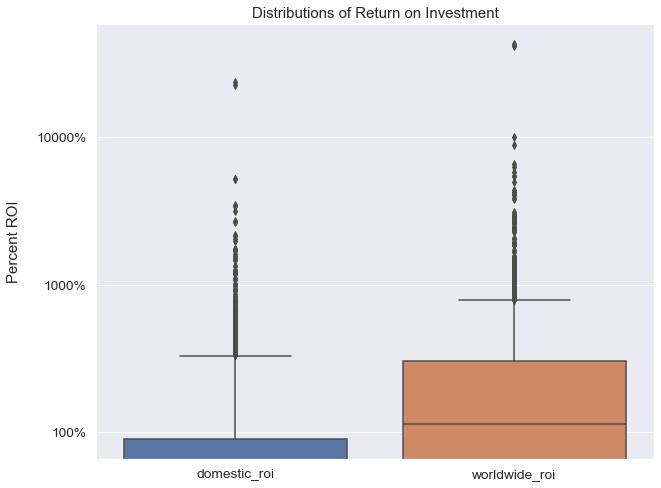

In [15]:
fix, ax = plt.subplots(figsize=(10, 8))
ax = sns.boxplot(data=tn[['domestic_roi', 'worldwide_roi']],
                 ax=ax,
                 palette='deep')
ax.set_title('Distributions of Return on Investment')
ax.set_ylabel('Percent ROI', labelpad=15)
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

Looks like there are some duplicate titles under `movie`, but those rows turn out to be acceptable.

In [16]:
cleaning.info(tn)

,dup,dup_%,nan,nan_%
tn_id,0,0.00,0,0.00
release_date,1329,66.72,0,0.00
release_year,1981,99.45,0,0.00
movie,4,0.20,0,0.00
production_budget,1687,84.69,0,0.00
domestic_gross,0,0.00,0,0.00
worldwide_gross,0,0.00,0,0.00
worldwide_profit,0,0.00,0,0.00
domestic_profit,0,0.00,0,0.00
worldwide_roi,1,0.05,0,0.00


In [17]:
tn[tn[['movie']].duplicated(keep=False)].sort_values('movie')

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
2140,2141,2009-12-04,2009,Brothers,"26,000,000.00","28,544,157.00","45,043,870.00","19,043,870.00","2,544,157.00",73.25,9.79
3307,3308,2015-08-14,2015,Brothers,"13,000,000.00","656,688.00","17,856,688.00","4,856,688.00","-12,343,312.00",37.36,-94.95
243,244,2015-03-27,2015,Home,"130,000,000.00","177,397,510.00","385,997,896.00","255,997,896.00","47,397,510.00",196.92,36.46
5459,5460,2009-04-23,2009,Home,"500,000.00","15,433.00","44,793,168.00","44,293,168.00","-484,567.00","8,858.63",-96.91
38,39,2010-05-14,2010,Robin Hood,"210,000,000.00","105,487,148.00","322,459,006.00","112,459,006.00","-104,512,852.00",53.55,-49.77
408,409,2018-11-21,2018,Robin Hood,"99,000,000.00","30,824,628.00","84,747,441.00","-14,252,559.00","-68,175,372.00",-14.40,-68.86
5009,5010,2010-04-09,2010,The Square,"1,900,000.00","406,216.00","740,932.00","-1,159,068.00","-1,493,784.00",-61.00,-78.62
5099,5100,2013-10-25,2013,The Square,"1,500,000.00","124,244.00","176,262.00","-1,323,738.00","-1,375,756.00",-88.25,-91.72


Time to save the data and move on.

In [18]:
tn.to_json(os.path.join('cleanData', 'tn.profit.json'))

### Internet Movie Database
After taking a look at my cleaning report, I can see that there are a number of duplicates under `primary_title` and many null values under `runtime_minutes`. I deal with the duplicates first, and later drop the `runtime_minutes` column altogether.

In [19]:
cleaning.info(imdb)

,dup,dup_%,nan,nan_%
runtime_minutes,145776,99.75,31739,21.72
genres,145058,99.26,5408,3.70
original_title,8370,5.73,21,0.01
tconst,0,0.00,0,0.00
primary_title,10073,6.89,0,0.00
start_year,146125,99.99,0,0.00


These duplicates are indeed going to be a problem.

In [20]:
imdb[imdb[['primary_title', 'original_title', 'start_year']
          ].duplicated(keep=False)].sort_values('primary_title')

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
103890,tt6085916,(aguirre),(aguirre),2016,97.00,"Biography,Documentary"
106201,tt6214664,(aguirre),(aguirre),2016,98.00,"Biography,Comedy,Documentary"
129962,tt8032828,100 Milioni di bracciate,100 Milioni di bracciate,2017,nan,Biography
129979,tt8034014,100 Milioni di bracciate,100 Milioni di bracciate,2017,nan,Biography
20394,tt1855110,180,180,2011,121.00,"Drama,Romance"
...,...,...,...,...,...,...
66990,tt3815124,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.00,"Biography,Documentary"
66992,tt3815128,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.00,"Biography,Documentary"
66995,tt3815134,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.00,"Biography,Documentary"
92592,tt5352034,Çagrilan,Çagrilan,2016,85.00,Horror


I drop rows with duplicates across `primary_title`, `original_title`, and `start_year`.

In [21]:
imdb.drop_duplicates(
    subset=['primary_title', 'original_title', 'start_year'], inplace=True)

Next I preprocess the titles of both `imdb` and `tn` in preparation for the merge. Since these tables do not share a unique identifier, I have to merge them using the year and title fields.

My string processing function makes all characters lowercase, removes punctuation, and translates Unicode characters to ASCII.

In [22]:
imdb['clean_title'] = cleaning.process_strings(imdb.loc[:, 'primary_title'])
tn = tn.assign(clean_title=cleaning.process_strings(tn['movie']))

I merge the tables crudely along the year and title fields. While this merge is sufficient for my analysis, it is inefficient. Some movies are lost in translation because their titles do not match character-for-character between tables.

In [23]:
imdb = pd.merge(imdb,
                tn,
                how='inner',
                left_on=['start_year', 'clean_title'],
                right_on=['release_year', 'clean_title'])
display(imdb.shape)
imdb.head()

(1387, 18)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,clean_title,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
0,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.00,"Adventure,Comedy,Drama",the secret life of walter mitty,437,2013-12-25,2013,The Secret Life of Walter Mitty,"91,000,000.00","58,236,838.00","187,861,183.00","96,861,183.00","-32,763,162.00",106.44,-36.00
1,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.00,"Action,Crime,Drama",a walk among the tombstones,2067,2014-09-19,2014,A Walk Among the Tombstones,"28,000,000.00","26,017,685.00","62,108,587.00","34,108,587.00","-1,982,315.00",121.82,-7.08
2,tt0369610,Jurassic World,Jurassic World,2015,124.00,"Action,Adventure,Sci-Fi",jurassic world,34,2015-06-12,2015,Jurassic World,"215,000,000.00","652,270,625.00","1,648,854,864.00","1,433,854,864.00","437,270,625.00",666.91,203.38
3,tt0376136,The Rum Diary,The Rum Diary,2011,119.00,"Comedy,Drama",the rum diary,1316,2011-10-28,2011,The Rum Diary,"45,000,000.00","13,109,815.00","21,544,732.00","-23,455,268.00","-31,890,185.00",-52.12,-70.87
4,tt0383010,The Three Stooges,The Three Stooges,2012,92.00,"Comedy,Family",the three stooges,1904,2012-04-13,2012,The Three Stooges,"30,000,000.00","44,338,224.00","54,052,249.00","24,052,249.00","14,338,224.00",80.17,47.79


Looks like the `start_year` range is appropriate. There is a large spike around 2010, which is not ideal. Unfortunately, I am working with a pretty small dataset at this point (~1400 observations), so I am reluctant to discard these early years.

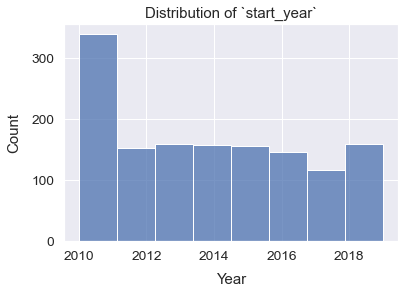

In [24]:
ax = sns.histplot(imdb, x='start_year', bins=8, palette='deep')
ax.set_title('Distribution of `start_year`')
ax.set_xlabel('Year', labelpad=10)
ax.yaxis.labelpad = 10

Next I drop all irrelevant or extraneous columns and check again for nulls and duplicates.

In [25]:
imdb.drop(columns=['start_year', 'release_year', 'clean_title',
          'movie', 'original_title', 'runtime_minutes'], inplace=True)

In [26]:
cleaning.info(imdb)

,dup,dup_%,nan,nan_%
tconst,0,0.00,0,0.00
primary_title,14,1.01,0,0.00
genres,1171,84.43,0,0.00
tn_id,14,1.01,0,0.00
release_date,820,59.12,0,0.00
production_budget,1146,82.62,0,0.00
domestic_gross,14,1.01,0,0.00
worldwide_gross,14,1.01,0,0.00
worldwide_profit,14,1.01,0,0.00
domestic_profit,14,1.01,0,0.00


Everything looks to be in order, but I need to convert the `genres` column from `string` to `list` in order to pull apart the individual genre labels.

In [27]:
imdb['genres'] = imdb.loc[:, 'genres'].str.split(',')
imdb[['genres']]

,genres
0,"[Adventure, Comedy, Drama]"
1,"[Action, Crime, Drama]"
2,"[Action, Adventure, Sci-Fi]"
3,"[Comedy, Drama]"
4,"[Comedy, Family]"
...,...
1382,"[Horror, Thriller]"
1383,"[Crime, Drama, Thriller]"
1384,"[Drama, Horror, Mystery]"
1385,[Documentary]


Time to inspect the distribution of genres.

In [28]:
imdb.explode('genres')['genres'].value_counts()

Drama          671
Comedy         488
Action         421
Adventure      345
Thriller       235
Crime          214
Romance        183
Horror         150
Biography      129
Sci-Fi         129
Fantasy        120
Mystery        115
Animation      100
Family          87
Music           50
History         39
Documentary     35
Sport           32
War             17
Western         10
Musical          9
Name: genres, dtype: int64

Inspecting the movies in the "Music" genre reveals that they are in fact musicals. I collapse these two labels into "Musical".

In [29]:
imdb.explode('genres').query('genres == "Music"').head()

,tconst,primary_title,genres,tn_id,release_date,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
30,tt0475290,"Hail, Caesar!",Music,2422,2016-02-05,"22,000,000.00","30,080,225.00","64,160,680.00","42,160,680.00","8,080,225.00",191.64,36.73
128,tt1017451,The Runaways,Music,3757,2010-03-19,"9,500,000.00","3,573,673.00","5,278,632.00","-4,221,368.00","-5,926,327.00",-44.44,-62.38
152,tt1068242,Footloose,Music,2339,2011-10-14,"24,000,000.00","51,802,742.00","62,989,834.00","38,989,834.00","27,802,742.00",162.46,115.84
170,tt1126591,Burlesque,Music,1024,2010-11-24,"55,000,000.00","39,440,655.00","90,552,675.00","35,552,675.00","-15,559,345.00",64.64,-28.29
195,tt1193631,Step Up 3D,Music,1909,2010-08-06,"30,000,000.00","42,400,223.00","165,889,117.00","135,889,117.00","12,400,223.00",452.96,41.33


In [30]:
imdb['genres'] = utils.map_list_likes(
    imdb['genres'], lambda x: 'Musical' if x == 'Music' else x)
imdb.explode('genres')['genres'].value_counts()

Drama          671
Comedy         488
Action         421
Adventure      345
Thriller       235
Crime          214
Romance        183
Horror         150
Biography      129
Sci-Fi         129
Fantasy        120
Mystery        115
Animation      100
Family          87
Musical         59
History         39
Documentary     35
Sport           32
War             17
Western         10
Name: genres, dtype: int64

Here is the final genre distribution chart. I choose to keep low-frequency genres like "War" and "Western" unless they prove disruptive.

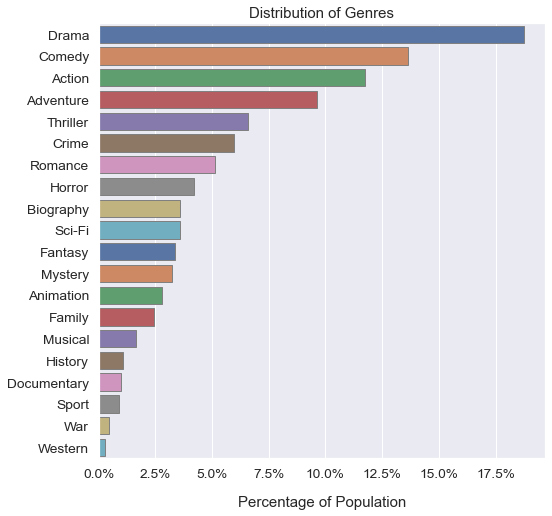

In [31]:
genre_counts = imdb.explode(
    'genres')['genres'].value_counts(normalize=True)
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.barplot(x=genre_counts.values,
                 y=genre_counts.index,
                 ec='gray',
                 ax=ax,
                 palette='deep')
ax.set_title('Distribution of Genres')
ax.set_xlabel('Percentage of Population', labelpad=15)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

Time to save the data and move on.

In [32]:
imdb.to_json(os.path.join('cleanData', 'imdb.tn.basics.json'))

 
## Data Modeling
### Cross-Tabulation
I begin by creating a movie-per-movie genre frequency table. Since no genre can occur more than once per movie, the frequencies can be interpreted as binary truth values. Now I can compute correlations between genres and financial outcomes.

In [33]:
combos = pd.crosstab(imdb.explode('genres')['tconst'], imdb.explode('genres')['genres'])
combos = combos.astype(np.bool_)
combos = combos.sort_index(axis=1).sort_index(axis=0)
combos.to_json(os.path.join('precomputed', 'genre_combos.json'))
combos.head()

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
tconst,,,,,,,,,,,,,,,,,,,,
tt0359950,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
tt0365907,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
tt0369610,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
tt0376136,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
tt0383010,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


I set the index of `imdb` to `tconst` for the upcoming computations. I need to use these unique IDs to relate the rows of `imdb` to the rows of `combos`.

In [34]:
imdb.set_index('tconst', inplace=True)

### Calculating Correlation
The **Pearson correlation coefficient** is a measure of the degree to which the relationship between two variables resembles a linear relationship. But it's hard to understand intuitively how genre could have anything approaching a linear relationship with, say, profit. What does that even mean?

It all makes good sense if you consider the following violin plots. The blobs indicate the location and density of the points in the distribution. Notice that genres which are positively correlated with profit have a fat violin on `False` and a narrow violin on `True`. Notice that genres which are negatively correlated with profit have a fat violin on `True` and a narrow violin on `False`. And finally, notice that genres with no correlation with profit have two fat violins.

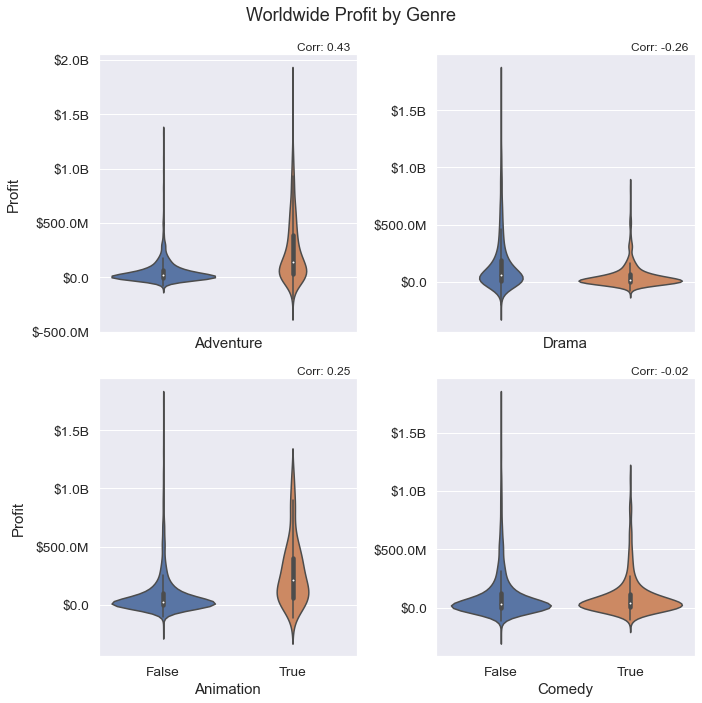

In [35]:
axs = plotting.boolean_violinplots(
        combos,
        imdb['worldwide_profit'],
        suptitle='Worldwide Profit by Genre',
        include=['Adventure', 'Drama', 'Animation', 'Comedy'],
        ylabel='Profit',
        figsize=(10, 10),
        palette='deep',
        saturation=0.75)
for ax in axs.flat:
        ax.yaxis.set_major_formatter(plotting.big_money_formatter(1))
plt.tight_layout()

### Correlation with Profit
Here are the correlations between each genre and worldwide profit. Notice that the frontrunners are "Adventure", "Animation", "Sci-Fi", and "Action". Also notice that "Drama" has the strongest negative correlation. This is an interesting result.

Text(0, 0.5, '')

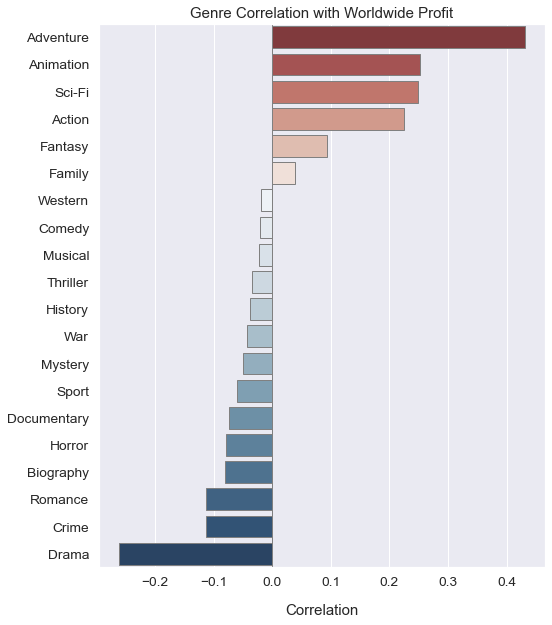

In [36]:
ax = plotting.cat_correlation(combos, imdb['worldwide_profit'])
ax.set_title('Genre Correlation with Worldwide Profit')
ax.set_ylabel(None)

As a sanity check, I plot the movies with the highest worldwide profit. Many adventure, sci-fi, and action titles show up: *The Avengers*,  *Jurassic World*, *Black Panther*. There are also several animated films: *Frozen*, *Beauty and the Beast*, *Incredibles 2*. Looks like the correlation numbers make sense.

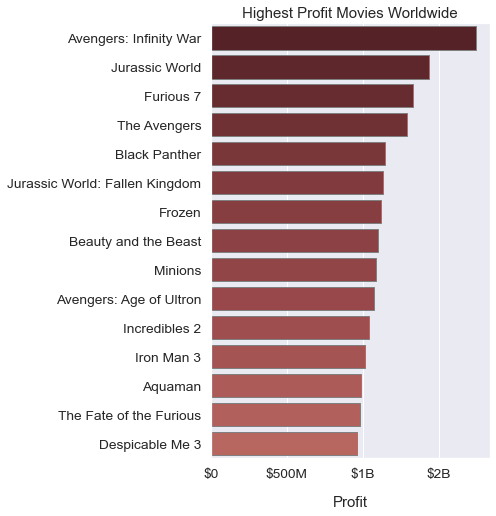

In [37]:
reds = sns.color_palette('Reds_r', 40, desat=0.6)
ax = plotting.topn_ranking(imdb, 
                            'primary_title', 
                            'worldwide_profit',
                            15,
                            figsize=(5, 8),
                            palette=reds)
ax.set_title('Highest Profit Movies Worldwide')
ax.set_ylabel(None)
ax.set_xlabel('Profit', labelpad=15)
ax.xaxis.set_major_formatter(plotting.big_money_formatter())

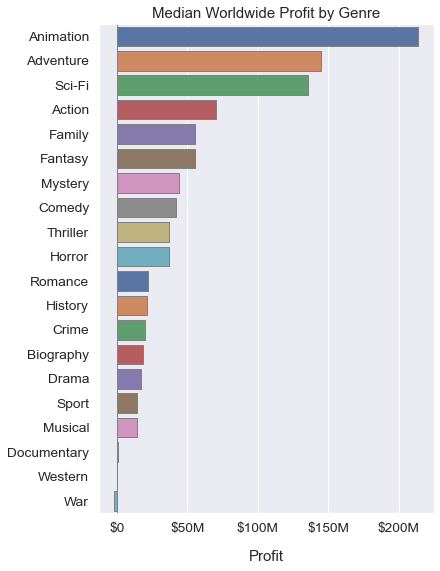

In [38]:
world_financials = imdb.explode('genres').groupby('genres').median()
world_financials = world_financials.filter(like='worldwide').reset_index()
ax = plotting.topn_ranking(world_financials, 'genres', 'worldwide_profit', 20, palette='deep', figsize=(6, 9))
ax.set_title('Median Worldwide Profit by Genre')
ax.set_ylabel(None)
ax.set_xlabel('Profit', labelpad=15)
ax.xaxis.set_major_formatter(plotting.big_money_formatter())
ax.axvline(x=0, color='gray', lw=1)

### Correlation with ROI
The correlations with worldwide ROI are strikingly different from those with profit. Horror? Mystery? Thriller? These all had a weak negative correlation with worldwide profit. Why are they suddenly the only positive values?

Here's my conjecture: it's because ROI places heavy weight on budget, and top-earning horror films are often very low-budget. A low-budget film can generate revenue which is exponentially higher than its budget. A high-budget film will have a hard time doing that.

Horror movies have a reputation for being low-budget. *Paranormal Activity*, for example, is well-known for its low budget. *The Blair Witch Project* is another obvious example, since it's just a shaky-cam movie with a bunch of kids in the woods. Nonetheless, both of these movies were highly successful at the box office.

Text(0.5, 0, 'Correlation')

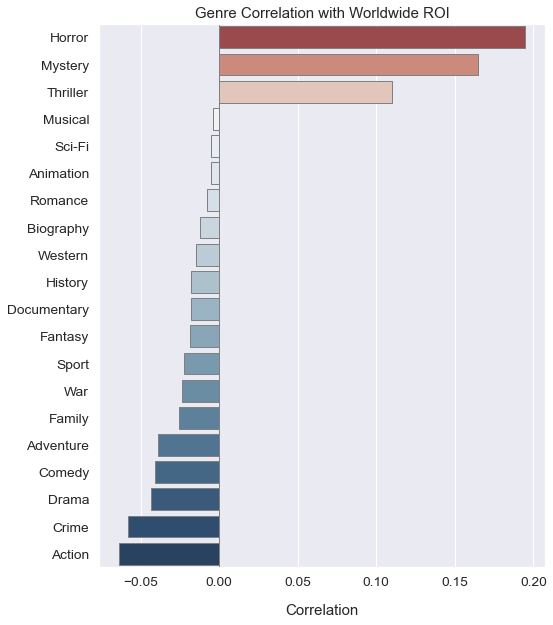

In [39]:
ax = plotting.cat_correlation(combos, imdb['worldwide_roi'])
ax.set_title('Genre Correlation with Worldwide ROI')
ax.set_ylabel(None)
ax.set_xlabel('Correlation', labelpad=15)

Here's another sanity check: the highest ROI movies worldwide. Nearly all of them are horror titles.

Text(0, 0.5, '')

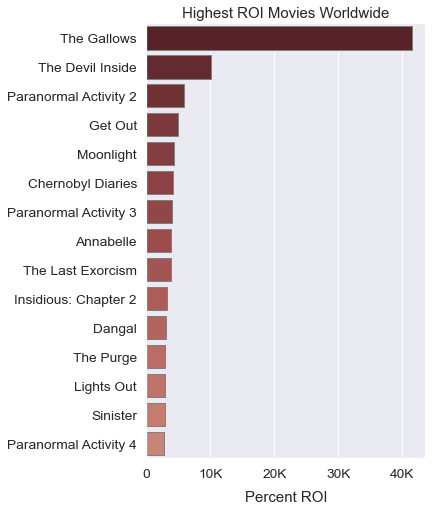

In [40]:
reds = sns.color_palette('Reds_r', 30, desat=0.6)
ax = plotting.topn_ranking(imdb,
                           'primary_title',
                           'worldwide_roi',
                           15,
                           figsize=(5, 8),
                           palette=reds)
ax.xaxis.set_major_formatter(plotting.big_number_formatter())
ax.set_title('Highest ROI Movies Worldwide')
ax.set_xlabel('Percent ROI', labelpad=10)
ax.set_ylabel(None)
# for tick in ax.get_xticklabels():
#     tick.set_rotation(45)

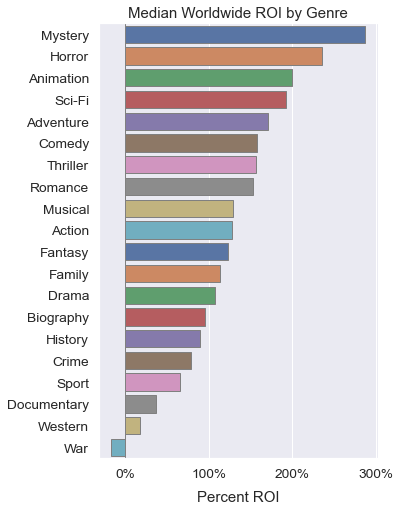

In [41]:
ax = plotting.topn_ranking(world_financials, 'genres', 'worldwide_roi', 24, palette='deep')
ax.axvline(x=0, color='gray', lw=1)
ax.set_title('Median Worldwide ROI by Genre')
ax.set_ylabel(None)
ax.set_xlabel('Percent ROI', labelpad=10)
ax.xaxis.set_major_formatter(ticker.PercentFormatter())

### Effects of Budget
Next, I partition the movies by budget quartile. "Low Budget" refers to the lower quartile (25th percentile) and below. "High Budget" refers to the upper quartile (75th percentile) and above. I want to plot the genre-ROI-correlations for low-budget films alongside those for high-budget films.

In [42]:
quartile_labels = ['Low Budget', 'Mid-low Budget',
                   'Mid-high Budget', 'High Budget']
imdb['budget_quartile'] = pd.qcut(
    imdb['production_budget'], 4, quartile_labels)
quartile_intervals = pd.qcut(imdb['production_budget'], 4).dtype.categories
world_roi_by_budget = combos.groupby(
    imdb['budget_quartile']).corrwith(imdb['worldwide_roi'])
world_roi_by_budget

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
budget_quartile,,,,,,,,,,,,,,,,,,,,
Low Budget,-0.05,-0.04,-0.02,-0.03,-0.08,-0.06,-0.05,-0.12,-0.04,0.00,-0.03,0.25,-0.04,0.23,-0.04,-0.01,-0.03,0.18,-0.03,-0.02
Mid-low Budget,-0.11,-0.04,-0.01,0.05,0.04,-0.13,0.00,0.02,0.00,-0.01,0.01,0.10,0.03,0.04,0.02,0.04,-0.05,0.05,-0.08,-0.04
Mid-high Budget,-0.02,-0.04,-0.02,-0.02,-0.03,-0.12,-0.05,-0.04,-0.04,-0.06,-0.01,0.02,0.19,0.03,0.11,0.04,-0.01,0.10,-0.06,0.02
High Budget,-0.15,0.15,0.25,0.01,0.14,-0.07,-0.02,-0.12,-0.03,-0.07,-0.02,-0.10,0.09,-0.02,-0.11,0.09,-0.05,-0.05,-0.03,-0.03


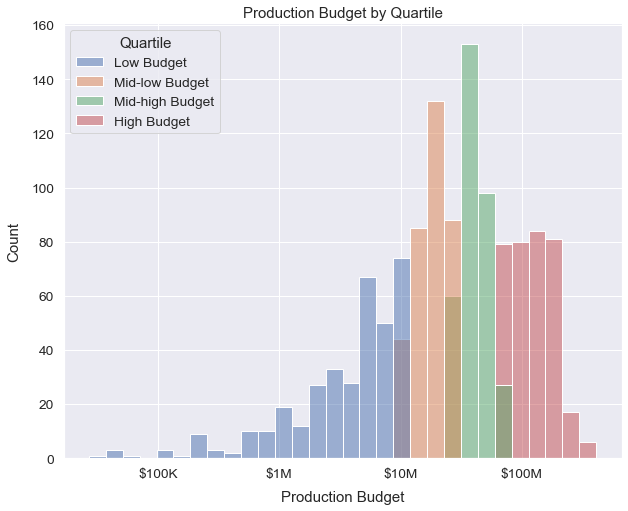

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.histplot(data=imdb, x='production_budget', hue='budget_quartile', ax=ax, log_scale=True, palette='deep')
ax.xaxis.set_major_formatter(plotting.big_money_formatter())
ax.get_legend().set_title('Quartile')
ax.set_title('Production Budget by Quartile')
ax.set_xlabel('Production Budget', labelpad=10)
ax.set_ylabel('Count', labelpad=10)
ax.xaxis.set_major_locator(ticker.LogLocator(subs=[1.0]))

Here's a plot of worldwide ROI computed separately for low-budget films and high-budget films. Looks like evidence supporting my conjecture that top-earning horror films are often very low-budget, and that low-budget movies are capable of achieving very high ROI.

Interestingly animation, and not adventure, is the frontrunner for high-budget films. Adventure, which led in correlation with worldwide profit, is now in second place.

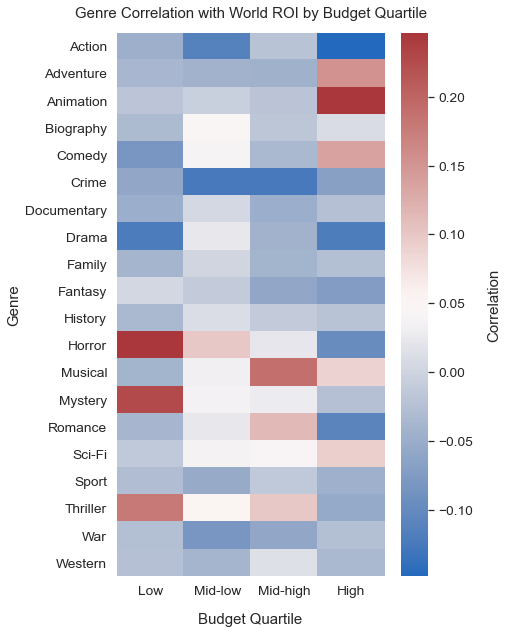

In [44]:
fig, ax = plt.subplots(figsize=(6,10))
short_quarts = ['Low', 'Mid-low', 'Mid-high', 'High']
ax = sns.heatmap(world_roi_by_budget.T, ax=ax, xticklabels=short_quarts, cmap='vlag')
ax.set_xlabel('Budget Quartile', labelpad=15)
ax.set_ylabel('Genre')
ax.set_title('Genre Correlation with World ROI by Budget Quartile', pad=15)
ax.collections[0].colorbar.set_label('Correlation', labelpad=15)

Next is the analogous plot for midrange budgets. The correlation scores here are lower, but you can see that Horror and Thriller are still at the top of the mix for mid-low budget films. It's notable that Musical and Romance movies lead the way for mid-high budget films. These genres definitely go together.

I perform the same calculations for domestic ROI. The results are similar, with some small differences. Notably, Comedy has risen up in ranking considerably for everything but low-budget films.

In [45]:
domestic_roi_by_budget = combos.groupby(
    imdb['budget_quartile']).corrwith(imdb['domestic_roi'])
domestic_roi_by_budget

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
budget_quartile,,,,,,,,,,,,,,,,,,,,
Low Budget,-0.06,-0.04,-0.02,-0.04,-0.07,-0.06,-0.04,-0.12,-0.03,0.01,-0.04,0.24,-0.05,0.21,-0.03,-0.01,-0.03,0.16,-0.03,-0.02
Mid-low Budget,-0.12,-0.01,0.01,0.04,0.09,-0.12,0.03,-0.04,0.08,-0.03,0.01,0.08,0.03,-0.01,0.04,0.04,-0.03,0.00,-0.10,-0.05
Mid-high Budget,-0.09,-0.07,-0.03,0.02,0.08,-0.07,-0.06,-0.05,0.00,-0.08,-0.05,-0.02,0.16,-0.03,0.10,-0.03,0.04,0.02,-0.06,0.05
High Budget,-0.18,0.07,0.22,0.05,0.19,-0.08,-0.05,-0.08,-0.00,-0.10,0.03,-0.11,0.11,-0.00,-0.08,0.08,-0.01,-0.10,-0.01,-0.02


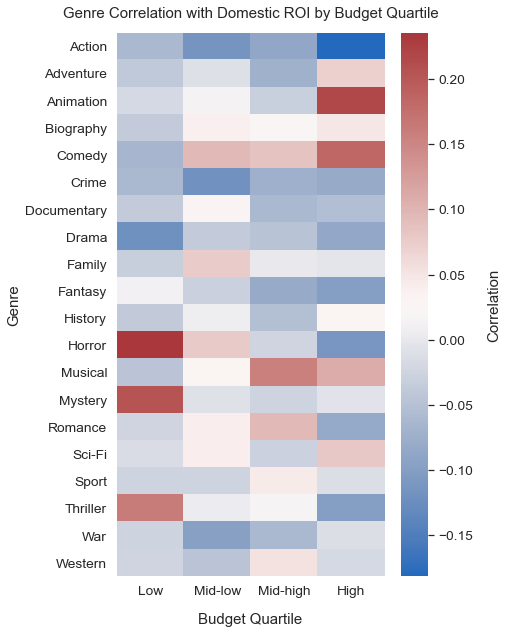

In [46]:
fig, ax = plt.subplots(figsize=(6,10))
ax = sns.heatmap(domestic_roi_by_budget.T, ax=ax, xticklabels=short_quarts, cmap='vlag')
ax.set_xlabel('Budget Quartile', labelpad=15)
ax.set_ylabel('Genre')
ax.set_title('Genre Correlation with Domestic ROI by Budget Quartile', pad=15)
ax.collections[0].colorbar.set_label('Correlation', labelpad=15)

### Budget Independently?
Could it be that low-budget movies simply have higher ROI in general than high-budget movies? No. Having a low-budget makes it possible to achieve an extremely high ROI percentage, but is not generally conducive to having high ROI. The following bivariate histogram shows that the highest concentration of movies is located between \\$10M and \\$100M (the mid-range quartiles) with an ROI in the 100s.

Text(0.5, 1.0, 'Distribution of Movies: Budget vs. World ROI')

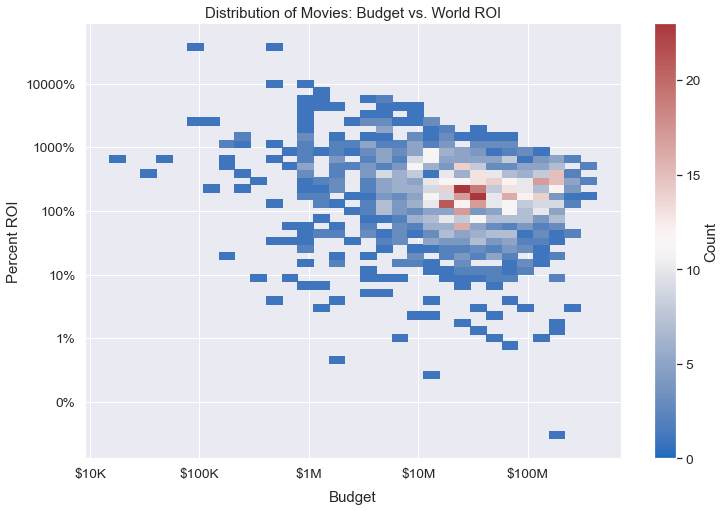

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))
cmap = sns.color_palette('vlag', as_cmap=True)
pos_world_rois = tn.query('worldwide_roi > 0')
ax = sns.histplot(data=pos_world_rois,
                  x='production_budget',
                  y='worldwide_roi',
                  ax=ax,
                  bins='auto',
                  stat='count',
                  cbar=True,
                  log_scale=True,
                  cmap=cmap,
                  cbar_kws={'label': 'Count'})
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_major_formatter(plotting.big_money_formatter())
ax.set_xlabel('Budget', labelpad=10)
ax.set_ylabel('Percent ROI')
ax.set_title('Distribution of Movies: Budget vs. World ROI')

Production budget has almost no correlation with world ROI, 
though it is weakly negative.

In [48]:
tn[['production_budget']].corrwith(tn['worldwide_roi'])

production_budget   -0.04
dtype: float64

## Conclusions

#### For high-budget productions, go with animation.
Animation has by far the strongest correlation (nearly 0.25) with ROI for high-budget films. The next best score is adventure, which is nearly 0.1 lower.

#### For low-budget productions, go with horror.
Nothing beats horror movies in terms of ROI, both overall and for low-budget films. The only other options are mystery and thriller, which both go along with horror anyway.

#### Stay away from drama, action, and crime.
Drama, action, and crime consistently show up in the negative on correlation with ROI. This means that movies achieve higher ROI when they are not drama, action, or crime. While it's possible to have success with these genres, they are the worst choices from an investment standpoint.

## Evaluation
My analysis provides some useful insights for Microsoft, but there is much more work to be done. For one, making a successful movie is much more complicated than choosing a genre. There are numerous other factors to consider, such as cast and crew.

Furthermore, I conducted my analysis with a very limited dataset of around 1,400 observations. Many movies were lost in the merge between `imdb` and `tn` because these tables had no unique identifiers in common. The merge could be improved by using fuzzy string matching or another sophisticated process for dirty merging. The ideal situation would be to find a source of data which provides both genre labels and finances.

Nonetheless, I am very confident in the finding that horror movies have the highest ROI. That was a very robust and striking pattern in the data. I am fairly confident in my other findings relating to the business recommendations, but I would like to conduct further research.